# Assignment 02     
## CSCI S-96    

> **Instructions:** For this assignment you will complete the exercises shown. All exercises involve creating and executing some Python code. Additionally, most exercises have questions for you to answer. You can answer questions by creating a Markdown cell and writing your answer. If you are not familiar with Markdown, you can find a brief tutorial [here](https://www.markdownguide.org/cheat-sheet/).   

In this assignment you will work with some basic streaming analytic algorithms. To avoid the complexities of installing and setting up a real streaming analytics platform,you will work with stream flow data loaded from local files. 

The United States Geological Survey (USGS) maintains over 13,500 stream flow gages in the United States. Measurements from most of these gages are recoded every 15 min and uploaded every 4 hours are [available for download](https://waterdata.usgs.gov/nwis/rt). Stream flow data are used as inputs for complex water management tasks for purposes such as agriculture, residential use and conservation. For this assignment you will work with the time series of measurements for two stream flow gages on tributaries of the the Columbia River in the US State of Washington.     

To get started, execute the code in the cell below to import the packages you will need. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Loading the Dataset  

The next step is to load the stream gage data. The code in the cell below loads the time series data for the first gage. This gage is sited on the Okanogan river.  

The code in the cell below does the following:  
1. Loads the data from a .csv file. 
2. Converts the time stamp column to an index of the Pandas data frame. 
3. Assigns human-understandable names to the columns.  
4. Returns just the first 4 columns of the data frame. 

Execute this code and examine the results.

In [2]:
def read_index_series(file_name):  
    df = pd.read_csv(file_name, sep='\t')
    df.index = df.datetime
    df.drop('datetime', axis=1, inplace=True)
    df = df.iloc[:,:4]
    df.columns = ['Agency', 'Site_number', 'Time_zone', 'Stream_flow']
    return df.iloc[:,:4]

Malott = read_index_series('../data/12447200_Okanogan_at_Malott.txt')
Malott

,Agency,Site_number,Time_zone,Stream_flow
datetime,,,,
2020-03-01 00:00,USGS,12447200,PST,2050
2020-03-01 00:15,USGS,12447200,PST,2050
2020-03-01 00:30,USGS,12447200,PST,2050
2020-03-01 00:45,USGS,12447200,PST,2050
2020-03-01 01:00,USGS,12447200,PST,2050
...,...,...,...,...
2020-08-31 22:45,USGS,12447200,PDT,1350
2020-08-31 23:00,USGS,12447200,PDT,1350
2020-08-31 23:15,USGS,12447200,PDT,1350


The other time series is for a gage on the Yakima River. Execute the code in the cell below and examine the result. 

In [3]:
CleElm = read_index_series('../data/12479500_Yakima_At_CleElm.txt')
CleElm

,Agency,Site_number,Time_zone,Stream_flow
datetime,,,,
2020-03-01 00:00,USGS,12484500,PST,1620
2020-03-01 00:15,USGS,12484500,PST,1620
2020-03-01 00:30,USGS,12484500,PST,1620
2020-03-01 00:45,USGS,12484500,PST,1620
2020-03-01 01:00,USGS,12484500,PST,1620
...,...,...,...,...
2020-08-31 22:45,USGS,12484500,PDT,3140
2020-08-31 23:00,USGS,12484500,PDT,3140
2020-08-31 23:15,USGS,12484500,PDT,3140


Since we really only want to work with one data frame. The code in the cell below merges the two time series and sorts them into time index order. Execute this code and examine the result, paying attention to the site number and the datetime index.  

In [4]:
stream_flow = Malott.append(CleElm).sort_index()
stream_flow

,Agency,Site_number,Time_zone,Stream_flow
datetime,,,,
2020-03-01 00:00,USGS,12447200,PST,2050
2020-03-01 00:00,USGS,12484500,PST,1620
2020-03-01 00:15,USGS,12484500,PST,1620
2020-03-01 00:15,USGS,12447200,PST,2050
2020-03-01 00:30,USGS,12447200,PST,2050
...,...,...,...,...
2020-08-31 23:15,USGS,12447200,PDT,1350
2020-08-31 23:30,USGS,12484500,PDT,3140
2020-08-31 23:30,USGS,12447200,PDT,1350


## Querying Stream Data

Common stream data operations are often formulated as queries on the stream data. Many streaming data platforms use extensions of SQL for these queries.   

To keep things simple in this assignment we will just use a simple query function. The function shown in the cell below supports simple queries on the    

In [68]:
def query_stream(df, Columns=None, site_numbers=None, start_time=None, end_time=None):    
    '''
    Function to query the stream gage time series data. The arguments are:    
    df = the data frame containing the data.  
    Columns = a list of columns to return.   
    site_numbers = a list of gage site numbers to return. 
    start_time = the start time of the returned data.   
    end_time = the end time of the returned data.
    '''
    ## First set values for arguments set to Null  
    if Columns==None: Columns = df.columns
    if start_time==None: start_time = df.index[0]
    if end_time==None: end_time = df.index[df.shape[0]-1]
    if site_numbers==None: site_numbers = df.Site_number.unique()
    ## Test if index is a string datetime or an integer
    ## use iloc method if an integer.
    ## A slice over the time range is created based on the index type. 
    if isinstance(start_time, str):
        df = df.loc[start_time:end_time,:]
    else:     
        df = df.iloc[start_time:end_time,:]
    df = df.loc[df.Site_number.isin(site_numbers), Columns]
    ## Return the results of the query
    return df

You can see the options to run `query_stream` function by executing the code in the cell below. 

In [35]:
print(query_stream.__doc__)


    Function to query the stream gage time series data. The arguments are:    
    df = the data frame containing the data.  
    Columns = a list of columns to return.   
    site_numbers = a list of gage site numbers to return. 
    start_time = the start time of the returned data.   
    end_time = the end time of the returned data.
    


An example of using the query function is shown in the cell below. Execute this code and examine the result. 

In [47]:
len(query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12484500]))

17660

> **Exercise 02-01:** Using the `query_stream` function, write and execute the code in the cell below to compute and display the mean `Stream_flow`for the month of April of 2020 of site 1248500. Use the [Pandas.DataFrame.mean](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html) method to compute the mean. Notice that using this approach we can compute most any statistic of interest on the query result.    

In [20]:
query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12484500], start_time='2020-04-01 00:00', end_time='2020-04-30 11:59').mean()

2238.241525423729

## Plotting Streaming Data

Visualization is important tool in data exploration and discovery. Numerical stream data is ideal for visual exploration if it can be subsampled to manageable size.  

The function in the cell below creates a time series plot. The time index of the Pandas data frame is used to generate the x-axis values. Execute the code in this cell to load this function.

In [8]:
def plot_time_series(df, ax=None): 
    if ax==None: fig, ax = plt.subplots(figsize=(20, 6))
    df.plot(ax=ax);
    ax.set_xlabel('Date');
    plt.show()
    return ax    

The code in the cell below creates time series plots of the stream flow data. The flow time series for two stream gages queried as arguments to the plot function. Execute this code and examine the results. 

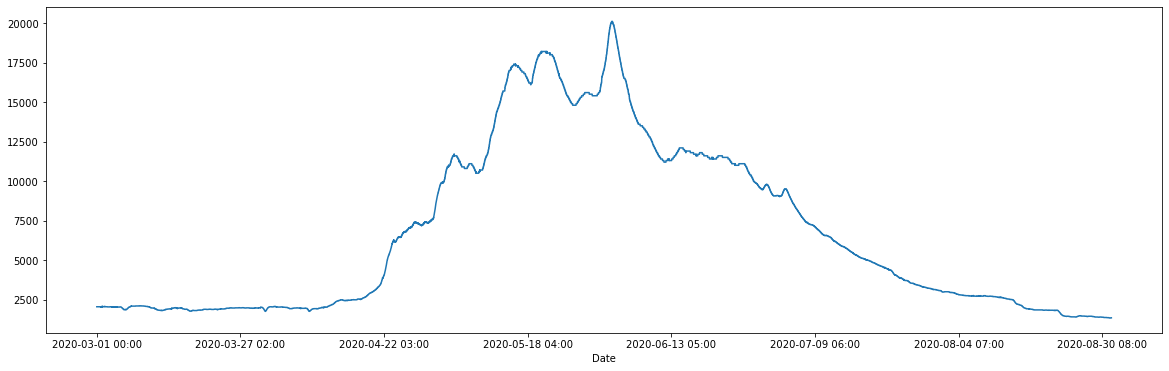

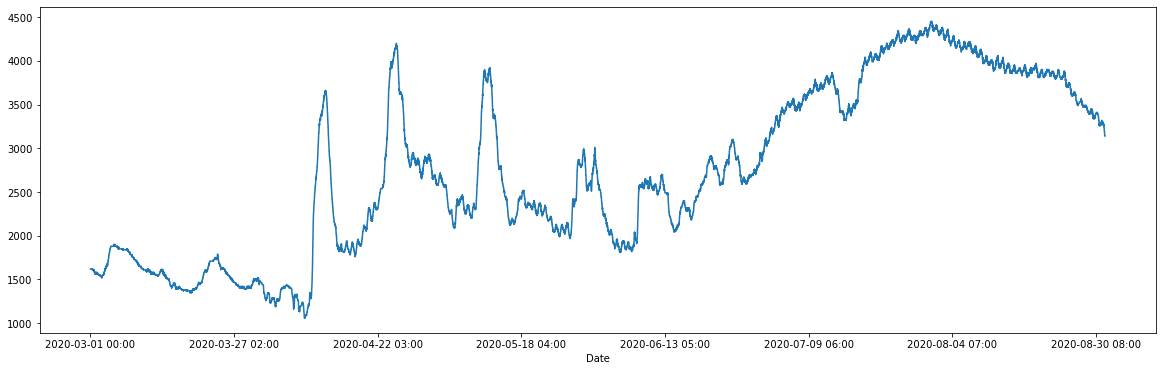

In [69]:
_=plot_time_series(query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12447200])) 
_=plot_time_series(query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12484500]))    

The time series of stream flow at both of these gages is rather complex. Both rivers have several dams used to control the flow. The flow is optimized to conserve fisheries and to supply agriculture in the Columbia River Basin. Water in reservoirs accumulates in the spring as mountain snow melts. The water is then is released throughout the spring and summer. 

But, what can we make of the noticeable spikes in flow, particularly for gage $12484500$ on the Yakima River. Even with the control provided by dams and reservoirs spring and early summer storm events can cause temporary increases in water flow. These storms bring heavy, and often warm, rain. Flow in the rivers increases not only because of the rainfall, but also since warm rain accelerates snow melt in the higher elevations.   

> **Exercise 02-02:** The transitory flow events on the Yakima River warrant some further investigation. You now have the tools to query and plot the stream flow time series. Your goal is to determine if there are common properties (e.g. duration or amplitude) of these events. Plot the results of a query for stream flows on gage $12484500$, Yakima River, from the 6th day of April to the 20th day of June, 2020. Discuss any common pattern in terms of approximately common amplitudes or durations of these events you can see.     

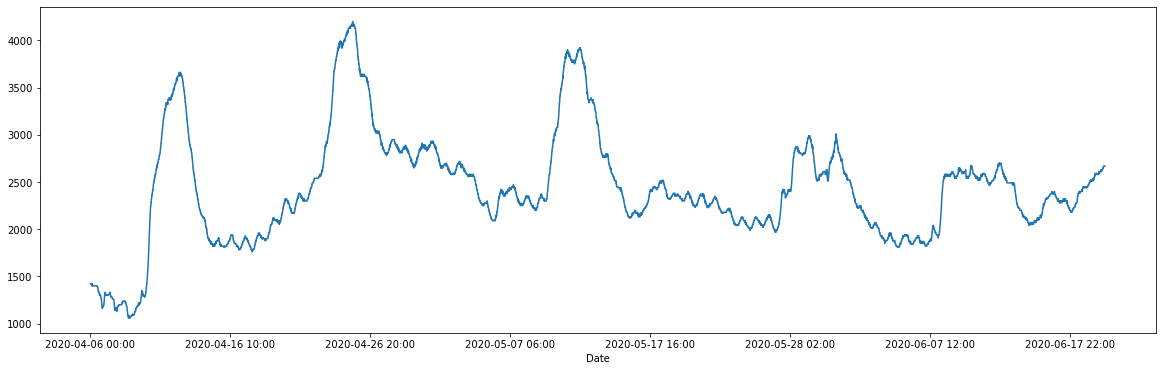

In [26]:
_=plot_time_series(query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12484500], start_time='2020-04-06 00:00', end_time='2020-06-20 11:59'))    

## Applying Moving Window Filters

Moving window filters are a commonly used method to compute statistical samples from streaming data. 

Apply a moving window filter. 

**Exercise 02-03:** You will complete and test the function in the cell below. 
> 1. Use a `for` loop to create the overlapping moving window samples of the input. 

In [90]:
def window_average(ts, length=12, stride=6, Columns='Stream_flow', site_numbers=[12484500]):
    half_length = int(length/2)-1
    idx = []
    out = []
    for ix_end in range(length, len(ts), stride):
        ix_start = ix_end - length  
        sample = query_stream(ts, Columns=Columns, site_numbers=site_numbers, start_time=ix_start, end_time=ix_end)
        out.append(sample.mean())
        idx.append(sample.index[half_length])
    out = pd.Series(out, index=idx)    
    return out     

In [92]:
Yakima = query_stream(stream_flow, site_numbers=[12484500])

filtered_12 = window_average(Yakima)
len(filtered_12)

2942

> Notice how the length of the time series has been significantly reduced. Is the reduction the 

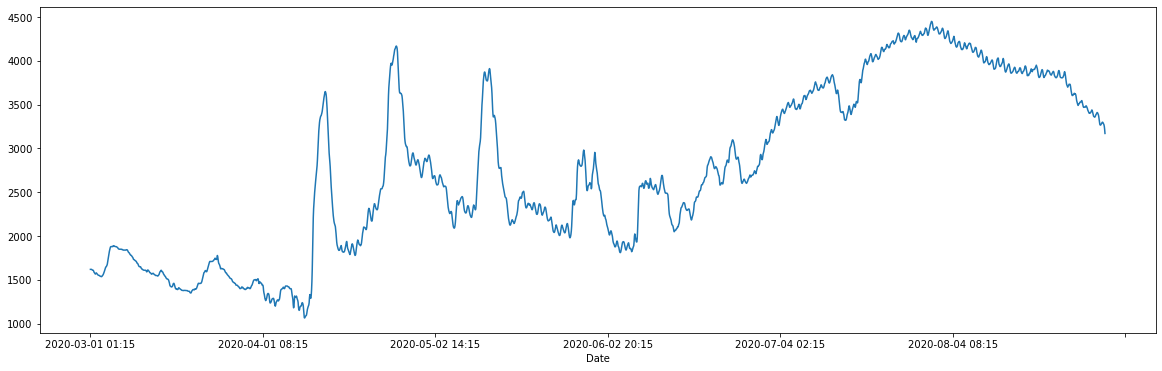

<AxesSubplot:xlabel='Date'>

In [93]:
plot_time_series(filtered_12)

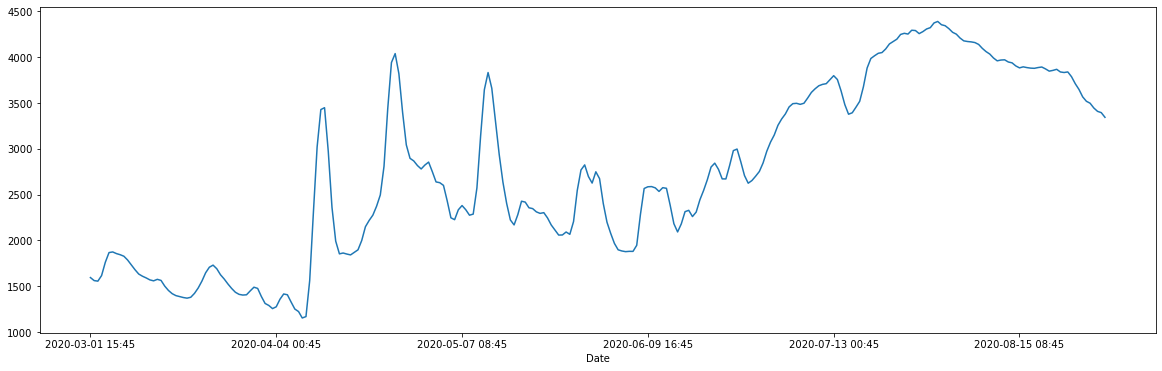

<AxesSubplot:xlabel='Date'>

In [95]:
filtered_128 = window_average(Yakima, length=128, stride=64)
len(filtered_128)
plot_time_series(filtered_128)

Exponential decay filter.

1103


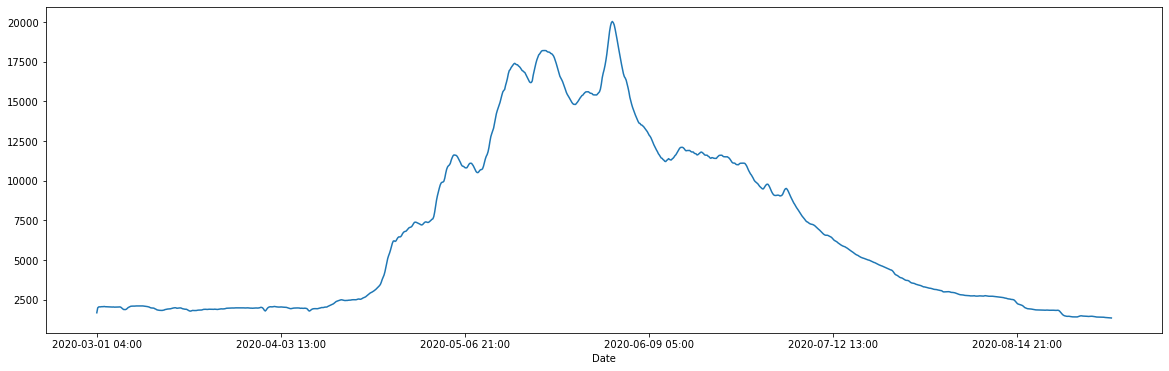

<AxesSubplot:xlabel='Date'>

In [15]:
def exponential_smooth(ts, alpha=0.1, step=16):
    in_index = ts.index
    idx = []
    samples=[0.0]
    out = []
    for ix in range(1,len(ts)):
        samples.append((1.0 - alpha) * samples[ix-1] + alpha * ts[ix])
        if ix % step == 0:
            out.append(samples[ix])
            idx.append(in_index[ix])
    out = pd.Series(out, index=idx)    
    return out       


smoothed_01 = exponential_smooth(query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12447200]))

print(len(smoothed_01))
plot_time_series(smoothed_01)

1103


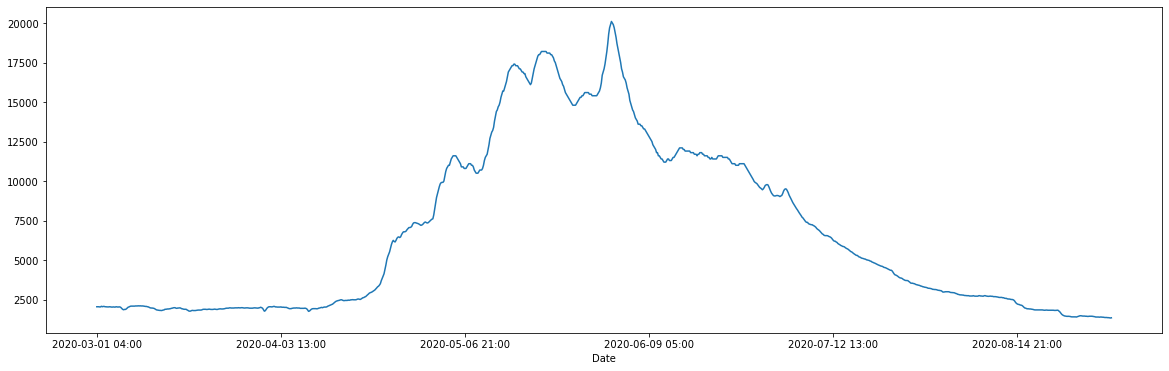

<AxesSubplot:xlabel='Date'>

In [27]:
smoothed_99 = exponential_smooth(query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12447200]), alpha=0.99, step=16)

print(len(smoothed_99))
plot_time_series(smoothed_99)

275


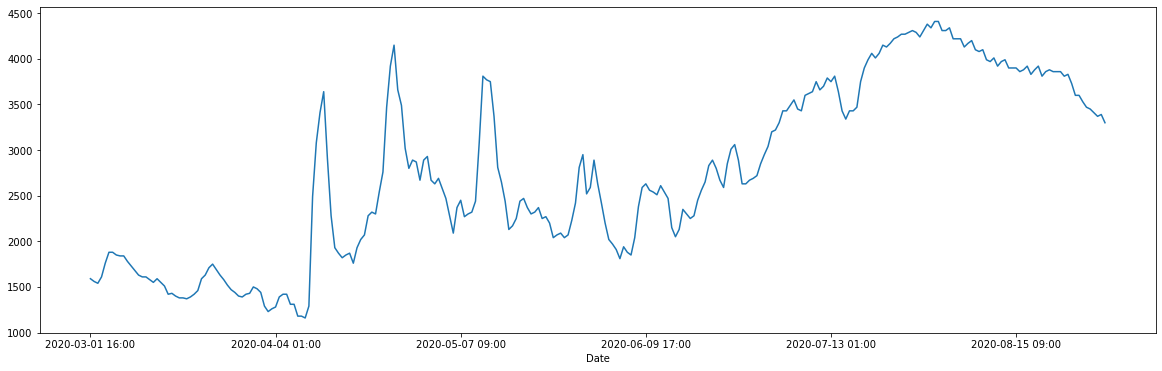

<AxesSubplot:xlabel='Date'>

In [17]:
smoothed_99 = exponential_smooth(query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12484500]), alpha=0.99, step=64)

print(len(smoothed_99))
plot_time_series(smoothed_99)